<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Relaxation and Decoherence*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Martin Sandberg, Hanhee Paik, Antonio Córcoles, Doug McClure, and Jay Gambetta

## Introduction

The interaction of quantum systems with their environment imposes certain limits and constraints on the study of their dynamics. The level of isolation of a quantum system dictates the rate at which it can exchange energy with its environment. This means that a quantum system will not hold a particular state for an arbitrary time, but will in general exchange energy with its environment and relax (or excite) to another state with different energy. This brings a trade-off in terms of controllability: a system that does not exchange much energy with the environment will keep its state for longer, but it will be more difficult to access and manipulate. 

Interaction with the environment can also result in decoherence, a process that does not result in energy exchange but that transforms quantum coherent states into classical mixed states.

These processes, energy relaxation and decoherence, are typically described by timescales referred to as $T_1$ and $T_2$, respectively.     

In [1]:
import sys, getpass
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
    print('Qconfig loaded from %s.' % Qconfig.__file__)
except:
    APItoken = getpass.getpass('Please enter your token: ')
    qx_config = {
        "APItoken": APItoken,
        "url":"https://quantumexperience.ng.bluemix.net/api"}
    print('Qconfig.py not found on Python path; Qconfig loaded from user input.')

please enter your token: ········
Qconfig.py not found on Python path; Qconfig loaded from qx_config in above code.


In [2]:
import qiskit as qk
import numpy as np
from scipy.optimize import curve_fit
from qiskit.tools.qcvv.fitters import exp_fit_fun, osc_fit_fun, plot_coherence

In [3]:
# function for padding with QId gates
def pad_QId(circuit,N,qr):
    # circuit to add to, N = number of QId gates to add, qr = qubit reg
    for ii in range(N):
        circuit.barrier(qr)
        circuit.iden(qr)
    return circuit    

In [4]:
qk.register(qx_config['APItoken'], qx_config['url'])

# backend and token settings
backend = qk.get_backend('ibmqx4') # the device to run on
shots = 1024    # the number of shots in the experiment 


# Measurement of $T_1$

Let's measure the relaxation time ($T_1$ time) of one of our qubits. To do this, we simply run a series of experiments in which we place the qubit in the excited state ($|1\rangle$) and measure its state after a delay time that is varied across the set of experiments. The probability of obtaining the state $|1\rangle$ decays exponentially as the delay time is increased; the characteristic time of this exponential is defined as $T_1$.

The IBM Q Experience does not currently support delays of arbitrary length, so for now, we just append a series of identity operations after the initial excitation pulse. Each identity operation has the same duration of a single-qubit gate and is followed by a -shorter- buffer time. These parameters are backend-dependent.

In [5]:
# Select qubit whose T1 is to be measured
qubit=1

# Creating registers
qr = qk.QuantumRegister(5)
cr = qk.ClassicalRegister(5)

# the delay times are all set in terms of single-qubit gates
# so we need to calculate the time from these parameters

params = backend.parameters['qubits'][qubit]
pulse_length=params['gateTime']['value'] # single-qubit gate time 
buffer_length=params['buffer']['value'] # spacing between pulses
unit = params['gateTime']['unit']

steps=10
gates_per_step=120
max_gates=(steps-1)*gates_per_step+1
tot_length=buffer_length+pulse_length
time_per_step=gates_per_step*tot_length
qc_dict={}
for ii in range(steps):
    step_num='step_%s'%(str(ii))
    qc_dict.update({step_num:qk.QuantumCircuit(qr, cr)})
    qc_dict[step_num].x(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].barrier(qr[qubit])
    qc_dict[step_num].measure(qr[qubit], cr[qubit])

circuits=list(qc_dict.values())    


In [6]:
# run the program
status = backend.status
if status['available'] == False or status['pending_jobs'] > 10:
    print('Warning: the selected backend appears to be busy or unavailable at present; consider choosing a different one if possible')
t1_job=qk.execute(circuits, backend, shots=shots)

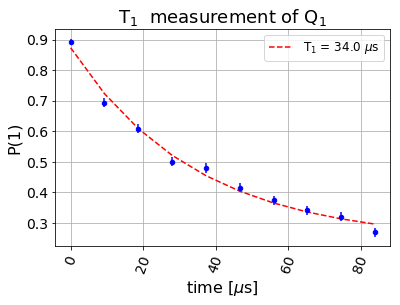

a: 0.63 ± 0.03
T1: 34.41 µs ± 4.45 µs
c: 0.24 ± 0.03


In [7]:
# arrange the data from the run

result_t1 = t1_job.result()
keys_0_1=list(result_t1.get_counts(qc_dict['step_0']).keys())# get the key of the excited state '00001' 

data=np.zeros(len(qc_dict.keys())) # numpy array for data
sigma_data = np.zeros(len(qc_dict.keys()))

# change unit from ns to microseconds
plot_factor=1
if unit.find('ns')>-1:
    plot_factor=1000
    punit='$\mu$s'
xvals=time_per_step*np.linspace(0,len(qc_dict.keys()),len(qc_dict.keys()))/plot_factor # calculate the time steps in microseconds 

for ii,key in enumerate(qc_dict.keys()):
    # get the data in terms of counts for the excited state normalized to the total number of counts
    data[ii]=float(result_t1.get_counts(qc_dict[key])[keys_0_1[1]])/shots
    sigma_data[ii] = np.sqrt(data[ii]*(1-data[ii]))/np.sqrt(shots)

# fit the data to an exponential    
fitT1, fcov = curve_fit(exp_fit_fun, xvals, data, bounds=([-1,2,0], [1., 500, 1])) 
ferr = np.sqrt(np.diag(fcov))

plot_coherence(xvals, data, sigma_data, fitT1, exp_fit_fun, punit, 'T$_1$ ', qubit)

print("a: " + str(round(fitT1[0],2)) + u" \u00B1 " + str(round(ferr[0],2)))
print("T1: " + str(round(fitT1[1],2))+ " µs" + u" \u00B1 " + str(round(ferr[1],2)) + ' µs')
print("c: " + str(round(fitT1[2],2)) + u" \u00B1 " + str(round(ferr[2],2)))

The last calibration of $T_1$ was measured to be

In [8]:
str(params['T1']['value']) +' ' + params['T1']['unit']

'53.4 µs'

# Measurement of $T_2^*$

We can also measure the coherence time of our qubits. In order to do this, we place the qubit in a superposition state and let it evolve before measuring in the $X$-basis. We will see that as time increases, the qubit evolves from a pure superposition state $|\Psi_s\rangle = |0 + 1\rangle$ to a mixture state $|\Psi_m\rangle = |0\rangle + |1\rangle$ with no phase information. 

In the actual experiment, we change the phase of the pulse before the measurement in order to create oscillations in the observed dynamics. If we just did two Hadamard gates separated by a delay, we would observe a decay of characteristic time $T^*_2$, but with a strong dependence on any deviation of the calibrated qubit frequency from the actual one. By implementing the qubit pulses with different phases, we shift the frequency dependence into the oscillating feature of the dynamics, and can fit the decaying envelope for a more faithful measure of the coherence time.

In [9]:
# Select qubit on which to measure T2*
qubit=1

# Creating registers
qr = qk.QuantumRegister(5)
cr = qk.ClassicalRegister(5)

params = backend.parameters['qubits'][qubit]
pulse_length=params['gateTime']['value'] # single-qubit gate time 
buffer_length=params['buffer']['value'] # spacing between pulses
unit = params['gateTime']['unit']

steps=35
gates_per_step=20
max_gates=(steps-1)*gates_per_step+2

num_osc=5
tot_length=buffer_length+pulse_length
time_per_step=gates_per_step*tot_length
qc_dict={}
for ii in range(steps):
    step_num='step_%s'%(str(ii))
    qc_dict.update({step_num:qk.QuantumCircuit(qr, cr)})
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].u1(2*np.pi*num_osc*ii/(steps-1),qr[qubit])
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num].barrier(qr[qubit])
    qc_dict[step_num].measure(qr[qubit], cr[qubit])
circuits=list(qc_dict.values())    


In [10]:
# run the program
status = backend.status
if status['available'] == False or status['pending_jobs'] > 10:
    print('Warning: the selected backend appears to be busy or unavailable at present; consider choosing a different one if possible')
t2star_job=qk.execute(circuits, backend, shots=shots)

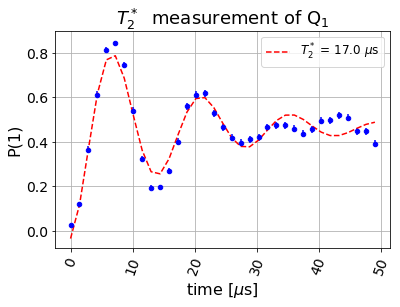

a: 0.5 ± 0.04
T2*: 16.55 µs ± 1.86 µs
f: 69.799kHz ± 1211.525kHz
phi: 3.22 ± 0.09
c: 0.46 ± 0.01


In [11]:
# arrange the data from the run

result_t2star = t2star_job.result()
keys_0_1=list(result_t2star.get_counts(qc_dict['step_0']).keys())# get the key of the excited state '00001' 

# change unit from ns to microseconds
plot_factor=1
if unit.find('ns')>-1:
    plot_factor=1000
    punit='$\mu$s'
xvals=time_per_step*np.linspace(0,len(qc_dict.keys()),len(qc_dict.keys()))/plot_factor # calculate the time steps 


data=np.zeros(len(qc_dict.keys())) # numpy array for data
sigma_data = np.zeros(len(qc_dict.keys()))

for ii,key in enumerate(qc_dict.keys()):
    # get the data in terms of counts for the excited state normalized to the total number of counts
    data[ii]=float(result_t2star.get_counts(qc_dict[key])[keys_0_1[1]])/shots
    sigma_data[ii] = np.sqrt(data[ii]*(1-data[ii]))/np.sqrt(shots)
    
fitT2s, fcov = curve_fit(osc_fit_fun, xvals, data, p0=[0.5, 100, 1/10, np.pi, 0], bounds=([0.3,0,0,0,0], [0.5, 200, 1/2,2*np.pi,1]))
ferr = np.sqrt(np.diag(fcov))

plot_coherence(xvals, data, sigma_data, fitT2s, osc_fit_fun, punit, '$T_2^*$ ', qubit)

print("a: " + str(round(fitT2s[0],2)) + u" \u00B1 " + str(round(ferr[0],2)))
print("T2*: " + str(round(fitT2s[1],2))+ " µs"+ u" \u00B1 " + str(round(ferr[1],2)) + ' µs')
print("f: " + str(round(10**3*fitT2s[2],3)) + 'kHz' + u" \u00B1 " + str(round(10**6*ferr[2],3)) + 'kHz')
print("phi: " + str(round(fitT2s[3],2)) + u" \u00B1 " + str(round(ferr[3],2)))
print("c: " + str(round(fitT2s[4],2)) + u" \u00B1 " + str(round(ferr[4],2)))

# Measurement of $T_2$ Echo

We have referred to the previous experiment's characteristic time as $T^*_2$ and not $T_2$ by analogy to nuclear magnetic resonance (NMR). Indeed, one can isolate different frequency components to the decoherence process by devising increasingly elaborated pulse sequences. To illustrate the analogy with NMR, one can think about an ensemble of nuclear spins precessing in an external DC magnetic field. Due to field inhomogeneities, each spin might precess with a slightly different Larmor frequency. This certainly will affect the observed coherence time of the ensemble. However, it is possible to echo away this low-frequency decoherence process by applying a pi-pulse to the system halfway through the delay. The effect of this pi-pulse is to reverse the direction of the precession of each individual spin due to field inhomogeneities. Thus, the spins that had precessed more now start precessing in the opposite direction faster than the spins that had precessed less, and after an equal delay, all the spins in the system recover the initial coherence, except for other, higher-frequency, decoherence mechanisms.

Here, we are measuring only a single qubit rather than an ensemble of spins, but coherence measurements require averaging an ensemble of measurements in order to eliminate projection noise, and run-to-run fluctuations in the qubit's frequency will similarly manifest themselves as decoherence if they are not canceled out. By running this $T_2$ echo sequence, we can therefore remove low-frequency components of the decoherence.

In [12]:
# Select qubit to measure T2 echo on
qubit=1

# Creating registers
qr = qk.QuantumRegister(5)
cr = qk.ClassicalRegister(5)

params = backend.parameters['qubits'][qubit]
pulse_length=params['gateTime']['value'] # single-qubit gate time 
buffer_length=params['buffer']['value'] # spacing between pulses
unit = params['gateTime']['unit']

steps=18
gates_per_step=28
tot_length=buffer_length+pulse_length
max_gates=(steps-1)*2*gates_per_step+3
time_per_step=(2*gates_per_step)*tot_length
qc_dict={}
for ii in range(steps):
    step_num='step_%s'%(str(ii))
    qc_dict.update({step_num:qk.QuantumCircuit(qr, cr)})
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].x(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num],gates_per_step*ii,qr[qubit])
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num].barrier(qr[qubit])
    qc_dict[step_num].measure(qr[qubit], cr[qubit])
circuits=list(qc_dict.values())    


In [13]:
# run the program
status = backend.status
if status['available'] == False or status['pending_jobs'] > 10:
    print('Warning: the selected backend appears to be busy or unavailable at present; consider choosing a different one if possible')
t2echo_job=qk.execute(circuits, backend, shots=shots)

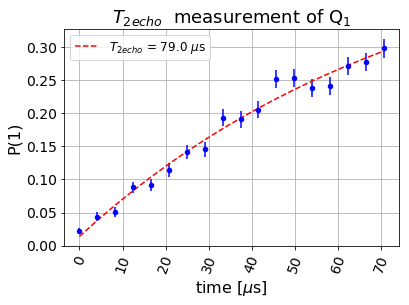

a: -0.47 ± 0.09
T2: 78.99 µs ± 24.38 µs
c: 0.49 ± 0.1


In [14]:
# arrange the data from the run

result_t2echo = t2echo_job.result()
keys_0_1=list(result_t2echo.get_counts(qc_dict['step_0']).keys())# get the key of the excited state '00001' 


# change unit from ns to microseconds
plot_factor=1
if unit.find('ns')>-1:
    plot_factor=1000
    punit='$\mu$s'
xvals=time_per_step*np.linspace(0,len(qc_dict.keys()),len(qc_dict.keys()))/plot_factor # calculate the time steps 


data=np.zeros(len(qc_dict.keys())) # numpy array for data
sigma_data = np.zeros(len(qc_dict.keys()))


for ii,key in enumerate(qc_dict.keys()):
    # get the data in terms of counts for the excited state normalized to the total number of counts
    data[ii]=float(result_t2echo.get_counts(qc_dict[key])[keys_0_1[1]])/shots
    sigma_data[ii] = np.sqrt(data[ii]*(1-data[ii]))/np.sqrt(shots)
    
fitT2e, fcov = curve_fit(exp_fit_fun, xvals, data, bounds=([-1,10,0], [1, 150, 1])) 
ferr = np.sqrt(np.diag(fcov))

plot_coherence(xvals, data, sigma_data, fitT2e, exp_fit_fun, punit, '$T_{2echo}$ ', qubit)

print("a: " + str(round(fitT2e[0],2)) + u" \u00B1 " + str(round(ferr[0],2)))
print("T2: " + str(round(fitT2e[1],2))+ ' µs' + u" \u00B1 " + str(round(ferr[1],2)) + ' µs')
print("c: " + str(round(fitT2e[2],2)) + u" \u00B1 " + str(round(ferr[2],2)))

The last calibration of $T_2$ was measured to be

In [15]:
str(params['T2']['value']) +' ' + params['T2']['unit']

'59.2 µs'

## CPMG measurement
 
As explained above, the echo sequence removes low-frequency decoherence mechanisms. This noise-filtering procedure can be extended with increased number of pi-pulses within the delay. In the following experiment, we implement an echo experiment with seven pi-pulses during the delay between the initial and final pulses. This kind of echo with several pi-pulses is referred to as a CPMG experiment, after Carr, Purcell, Meiboom, and Gill.  

In [16]:
# Select qubit for CPMG measurement of T2
qubit=1

# Creating registers
qr = qk.QuantumRegister(5)
cr = qk.ClassicalRegister(5)

params = backend.parameters['qubits'][qubit]
pulse_length=params['gateTime']['value'] # single-qubit gate time 
buffer_length=params['buffer']['value'] # spacing between pulses
unit = params['gateTime']['unit']

steps=10
gates_per_step=18
num_echo=5 # has to be odd number to end up in excited state at the end
tot_length=buffer_length+pulse_length
time_per_step=((num_echo+1)*gates_per_step+num_echo)*tot_length
max_gates=num_echo*(steps-1)*gates_per_step+num_echo+2
qc_dict={}
for ii in range(steps):
    step_num='step_%s'%(str(ii))
    qc_dict.update({step_num:qk.QuantumCircuit(qr, cr)})
    qc_dict[step_num].h(qr[qubit])
    for iii in range(num_echo):
        qc_dict[step_num]=pad_QId(qc_dict[step_num], gates_per_step*ii, qr[qubit])
        qc_dict[step_num].x(qr[qubit])
    qc_dict[step_num]=pad_QId(qc_dict[step_num], gates_per_step*ii, qr[qubit])
    qc_dict[step_num].h(qr[qubit])
    qc_dict[step_num].barrier(qr[qubit])
    qc_dict[step_num].measure(qr[qubit], cr[qubit])
circuits=list(qc_dict.values())


In [17]:
# run the program
status = backend.status
if status['available'] == False or status['pending_jobs'] > 10:
    print('Warning: the selected backend appears to be busy or unavailable at present; consider choosing a different one if possible')
t2cpmg_job=qk.execute(circuits, backend, shots=shots)

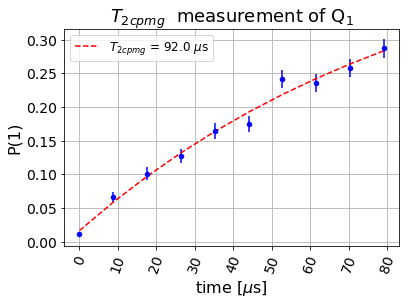

a: -0.46 ± 0.12
T2: 91.8 µs ± 36.02 µs
c: 0.48 ± 0.12


In [18]:
# arrange the data from the run

result_t2cpmg = t2cpmg_job.result()
keys_0_1=list(result_t2cpmg.get_counts(qc_dict['step_0']).keys())# get the key of the excited state '00001' 


# change unit from ns to microseconds
plot_factor=1
if unit.find('ns')>-1:
    plot_factor=1000
    punit='$\mu$s'
xvals=time_per_step*np.linspace(0,len(qc_dict.keys()),len(qc_dict.keys()))/plot_factor # calculate the time steps 


data=np.zeros(len(qc_dict.keys())) # numpy array for data
sigma_data = np.zeros(len(qc_dict.keys()))

for ii,key in enumerate(qc_dict.keys()):
    # get the data in terms of counts for the excited state normalized to the total number of counts
    data[ii]=float(result_t2cpmg.get_counts(qc_dict[key])[keys_0_1[1]])/shots
    sigma_data[ii] = np.sqrt(data[ii]*(1-data[ii]))/np.sqrt(shots)
    
fitT2cpmg, fcov = curve_fit(exp_fit_fun, xvals, data, bounds=([-1,10,0], [1, 150, 1])) 
ferr = np.sqrt(np.diag(fcov))

plot_coherence(xvals, data, sigma_data, fitT2cpmg, exp_fit_fun, punit, '$T_{2cpmg}$ ', qubit)

print("a: " + str(round(fitT2cpmg[0],2)) + u" \u00B1 " + str(round(ferr[0],2)))
print("T2: " + str(round(fitT2cpmg[1],2))+ ' µs' + u" \u00B1 " + str(round(ferr[1],2)) + ' µs')
print("c: " + str(round(fitT2cpmg[2],2)) + u" \u00B1 " + str(round(ferr[2],2)))

In [19]:
%run "../../version.ipynb"

Package,Version
QISKit,0.5.0
numpy,">= 1.13, < 1.14"
scipy,">= 0.19, < 0.20"
matplotlib,">= 2.0, < 2.1"


Installed packages are as the following



Python 3.6.5 :: Anaconda, Inc.


# packages in environment at C:\Users\IBM_ADMIN\Anaconda3\envs\QISKitPIP:
#
IBMQuantumExperience      1.9.1                     <pip>
matplotlib                2.1.2                     <pip>
numpy                     1.14.3                    <pip>
numpy                     1.13.1                   py36_0  
numpydoc                  0.7.0            py36ha25429e_0  
qiskit                    0.5.1                     <pip>
scipy                     0.19.1              np113py36_0  
scipy                     1.0.1                     <pip>
